In [10]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import setup as su
import explotaryDataAnalysis as eda
import dataPreprocessing as dp


#### Libraries for Setup

In [11]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

#### Helper Functions for Setup

In [12]:
# Function to load dataset
def load_dataset(file_path):
    return pd.read_csv(file_path)

# Function to check for missing values
def check_missing_values(df):
    return df.isnull().sum()

# Function to encode categorical variables
def encode_categorical_variables(df):
    return pd.get_dummies(df)

# Function to scale numerical features
def scale_numerical_features(df, numerical_features):
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    return df

def convert_string_columns(df):
    """
    Converts string data to the appropriate type in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The processed DataFrame with string data converted.
    """
    # Convert string data to the appropriate type
    string_col = df.select_dtypes(include="object").columns
    df[string_col] = df[string_col].astype("string")
    
    return df

def get_categorical_columns(df):
    """
    Returns a list of categorical columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    list: A list of categorical column names.
    """
    string_col = df.select_dtypes("string").columns.to_list()
    return string_col

def get_numerical_columns(df, exclude_col):
    """
    Returns a list of numerical columns in the DataFrame excluding specified columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    exclude_col (str): The column to exclude from the numerical columns.

    Returns:
    list: A list of numerical column names excluding the specified column.
    """
    string_col = get_categorical_columns(df)
    num_col = df.columns.to_list()
    for col in string_col:
        num_col.remove(col)
    if exclude_col in num_col:
        num_col.remove(exclude_col)
    return num_col

In [13]:
file_path = './Data/heart.csv'
    
# Load the dataset
heart_df = load_dataset(file_path)

# convert string data to appropriate type
heart_df = convert_string_columns(heart_df)

categorical_columns = get_categorical_columns(heart_df)  # Get categorical columns
numerical_columns = get_numerical_columns(heart_df, None)  # Get numerical columns excluding "HeartDisease"

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


#### Libraries for Explanatory Data Analysis

In [14]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

In [15]:
def create_correlation_matrix(df, columns, column_type='numerical', title="Correlation Matrix"):
    """
    Creates a correlation matrix using Seaborn and computes correlation for either numerical or categorical columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): The columns to include in the correlation computation.
    column_type (str): The type of columns to compute correlation for ('numerical' or 'categorical').
    title (str): The title of the correlation matrix plot.

    Returns:
    None
    """
    if column_type == 'numerical':
        # Compute correlation matrix for numerical columns
        corr_matrix = df[columns].corr()
    elif column_type == 'categorical':
        # Convert categorical columns to numerical using Label Encoding
        df_encoded = df[columns].apply(lambda col: pd.factorize(col, sort=True)[0])
        corr_matrix = df_encoded.corr()
    else:
        raise ValueError("column_type must be either 'numerical' or 'categorical'")

    # Plot the correlation matrix using seaborn
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()

def create_clustermap(df, columns, column_type='numerical', title="Clustermap", n_clusters=3, linkage_method='single'):
    """
    Creates a clustermap using Seaborn with hierarchical clustering.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): The columns to include in the correlation computation.
    column_type (str): The type of columns to compute correlation for ('numerical' or 'categorical').
    title (str): The title of the clustermap plot.
    n_clusters (int): The number of clusters to form.
    linkage_method (str): The linkage algorithm to use for hierarchical clustering.

    Returns:
    None
    """
    if column_type == 'numerical':
        # Compute correlation matrix for numerical columns
        corr_matrix = df[columns].corr()
    elif column_type == 'categorical':
        # Convert categorical columns to numerical using Label Encoding
        df_encoded = df[columns].apply(lambda col: pd.factorize(col, sort=True)[0])
        corr_matrix = df_encoded.corr()
    else:
        raise ValueError("column_type must be either 'numerical' or 'categorical'")

    # Perform hierarchical clustering
    distance_matrix = 1 - corr_matrix.abs()  # Convert correlation matrix to distance matrix
    condensed_distance = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_distance, method=linkage_method)
    
    # Cut the dendrogram to form clusters
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    
    # Create a DataFrame for cluster assignment
    cluster_df = pd.DataFrame(data={'Cluster': clusters}, index=corr_matrix.index)
    
    # Create a clustermap
    cg = sns.clustermap(corr_matrix, row_cluster=True, col_cluster=True, row_linkage=Z, col_linkage=Z, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    
    # Add cluster annotations
    for i, cluster in enumerate(cluster_df['Cluster']):
        cg.ax_row_dendrogram.bar(0, 0, color=plt.cm.tab10(cluster / n_clusters), label=f'Cluster {cluster}', linewidth=0)
    
    # Add a legend with clusters
    handles, labels = cg.ax_row_dendrogram.get_legend_handles_labels()
    unique_labels = [f'Cluster {i}' for i in range(1, n_clusters + 1)]
    cg.ax_row_dendrogram.legend(handles[:n_clusters], unique_labels, loc='center', ncol=n_clusters, frameon=False)
    
    plt.title(title)
    plt.show()

def draw_histogram(df, x_column, color_column, title):
    """
    Draws a histogram using Plotly Express.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x_column (str): The column to be used on the x-axis.
    color_column (str): The column to be used for color grouping.
    title (str): The title of the histogram.

    Returns:
    None
    """
    fig = px.histogram(
        df,
        x=x_column,
        color=color_column,
        hover_data=df.columns,
        title=title,
        barmode="group"
    )
    fig.show()

def create_pairplot(df, hue_column=None, title="Pairplot"):
    """
    Creates a pairplot using Seaborn to show pairwise bivariate distributions in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    hue_column (str): The column to use for hue (optional).
    title (str): The title of the pairplot.

    Returns:
    None
    """
    plt.figure(figsize=(15, 10))
    sns.pairplot(df, hue=hue_column)
    plt.suptitle(title, y=1.02)  # Adjust y for the title to be above the plot
    plt.tight_layout()
    plt.show()

def plot_distributions(df, title="Distribution of Data"):
    """
    Plots the distribution of each variable in the DataFrame with a kernel density estimate.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    title (str): The overall title of the plots.

    Returns:
    None
    """
    num_columns = len(df.columns)
    num_rows = (num_columns // 3) + 1 if num_columns % 3 != 0 else num_columns // 3
    
    plt.figure(figsize=(15, num_rows * 5))
    
    for i, col in enumerate(df.columns, 1):
        plt.subplot(num_rows, 3, i)
        plt.title(f"Distribution of {col} Data")
        sns.histplot(df[col], kde=True)
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

def create_box_plot(df, x_column, y_column, title="Box Plot"):
    """
    Creates a box plot using Plotly Express.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    x_column (str): The column to be used on the x-axis.
    y_column (str): The column to be used on the y-axis.
    title (str): The title of the box plot.

    Returns:
    None
    """
    fig = px.box(df, y=y_column, x=x_column, title=title)
    fig.show()  

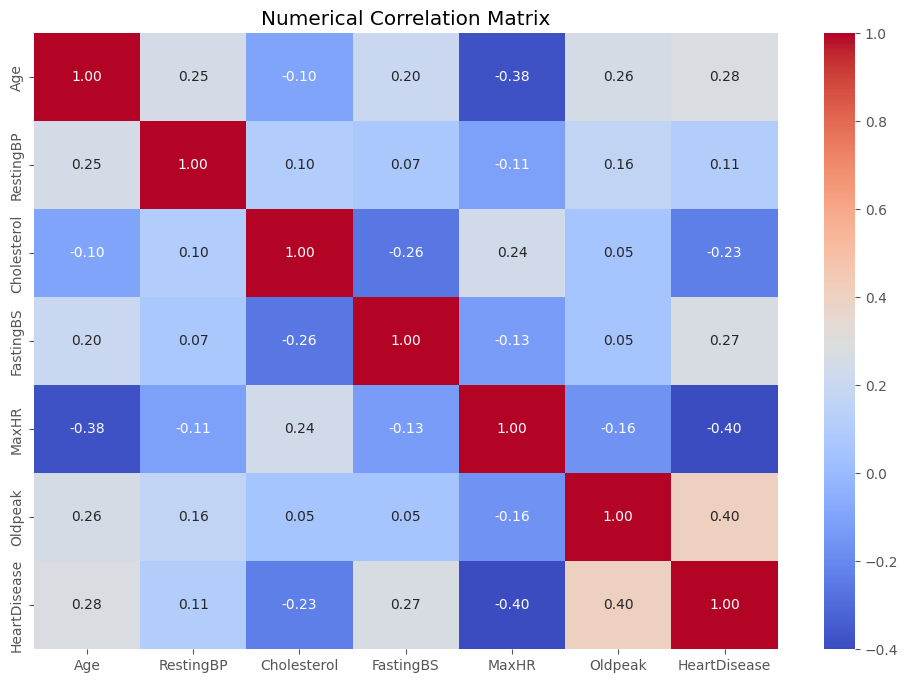

In [18]:
# Create correlation matrix for numerical columns
create_correlation_matrix(heart_df, columns=numerical_columns, column_type='numerical', title="Numerical Correlation Matrix")

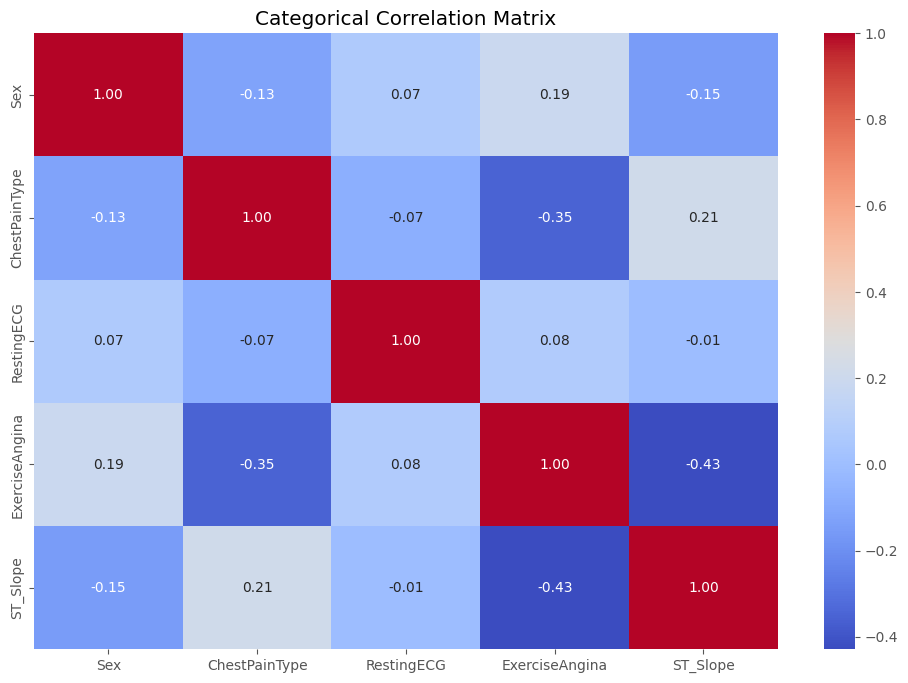

In [17]:
# Create correlation matrix for categorical columns
create_correlation_matrix(heart_df, columns=categorical_columns, column_type='categorical', title="Categorical Correlation Matrix")

In [19]:
# Create histogram:
draw_histogram(heart_df, "HeartDisease", "Sex", "Distribution of Heart Diseases by Sex")
draw_histogram(heart_df, "ChestPainType", "Sex", "Types of Chest Pain by Sex")
draw_histogram(heart_df, "Sex", None, "Sex Ratio in Data")
draw_histogram(heart_df, "RestingECG", None, "Distribution of ECG")

<Figure size 1500x1000 with 0 Axes>

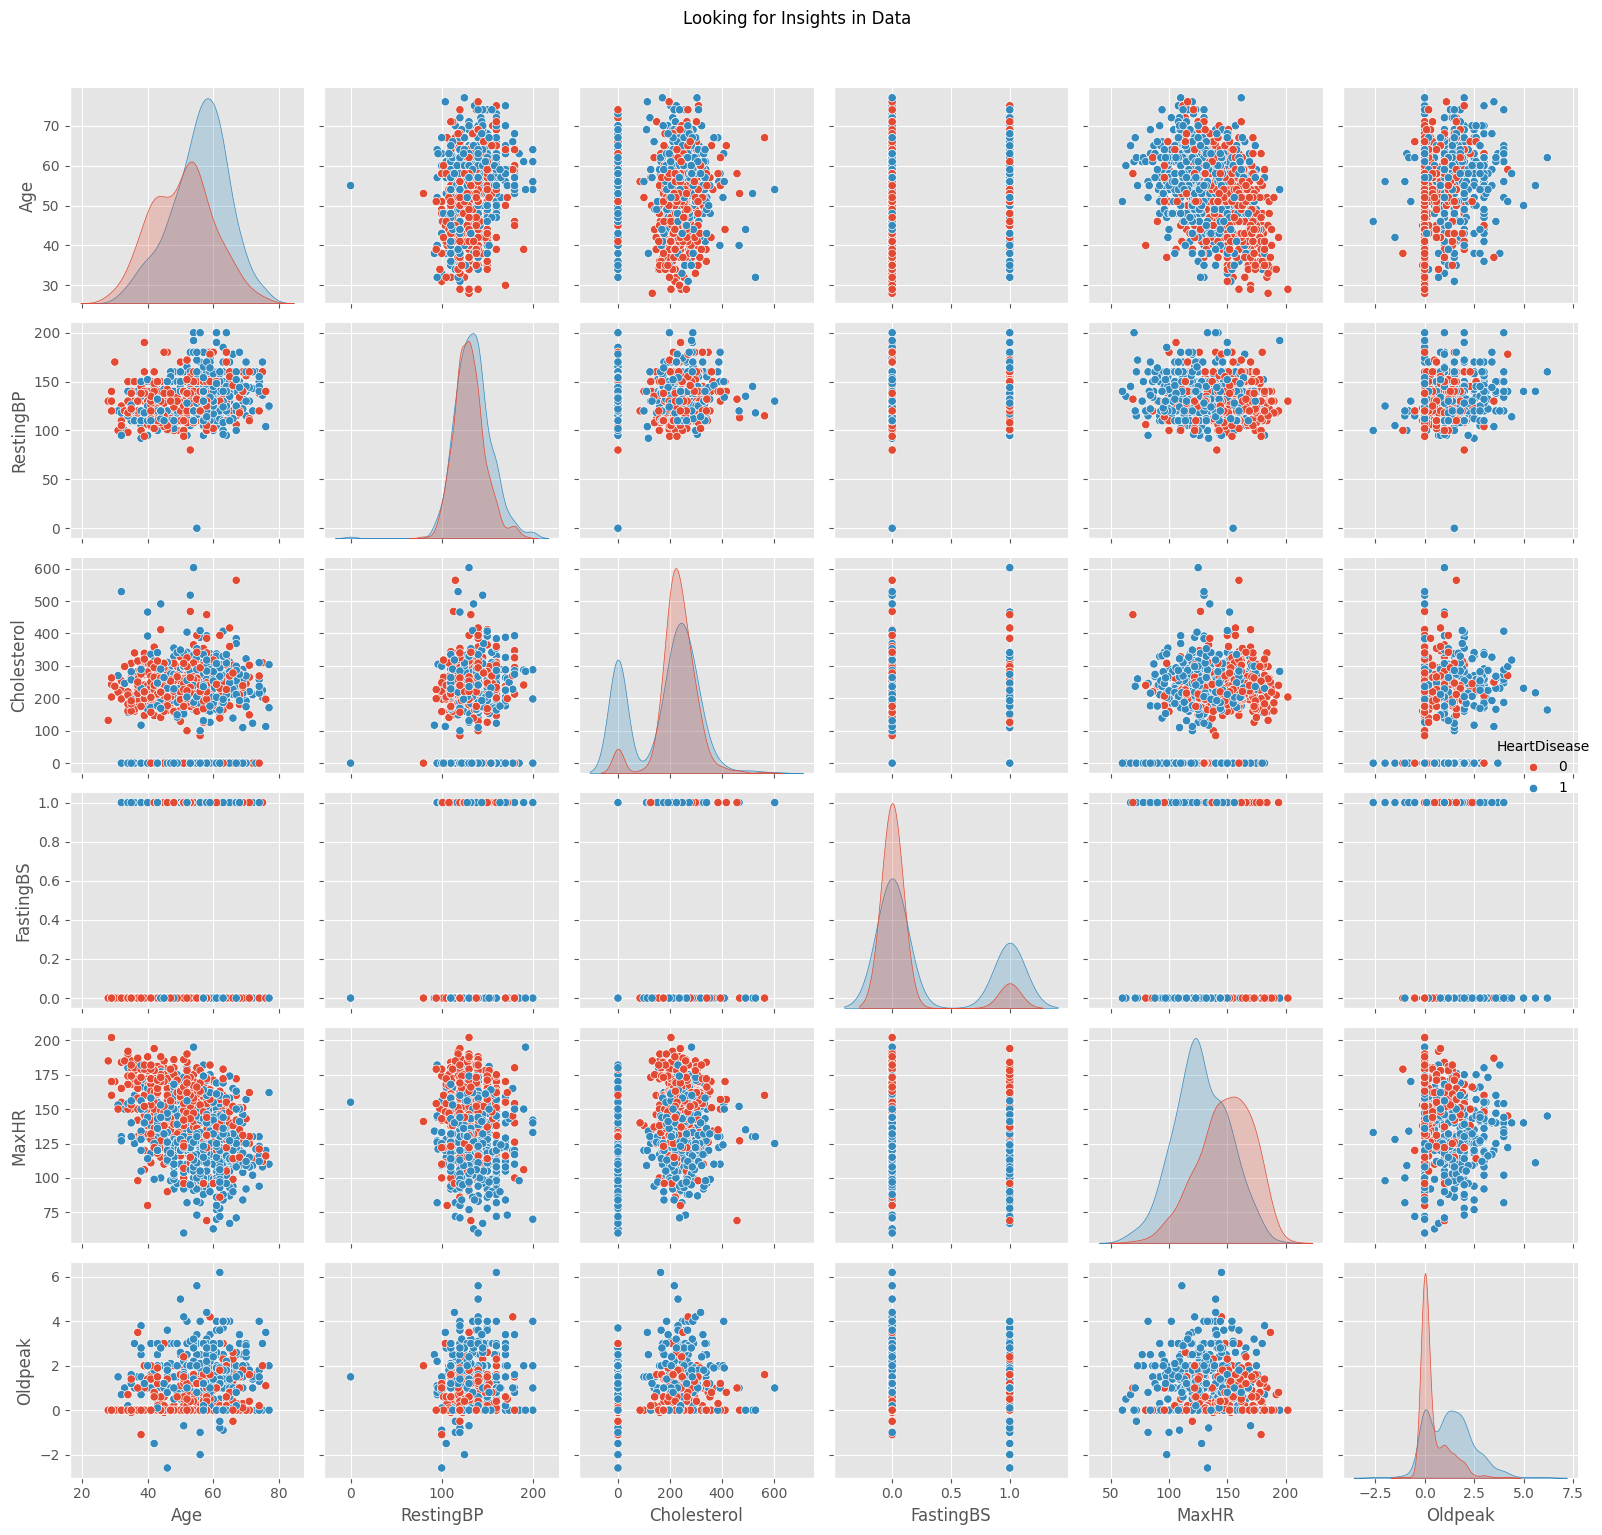

In [21]:
 # Create pairplot
create_pairplot(heart_df, hue_column="HeartDisease", title="Looking for Insights in Data")

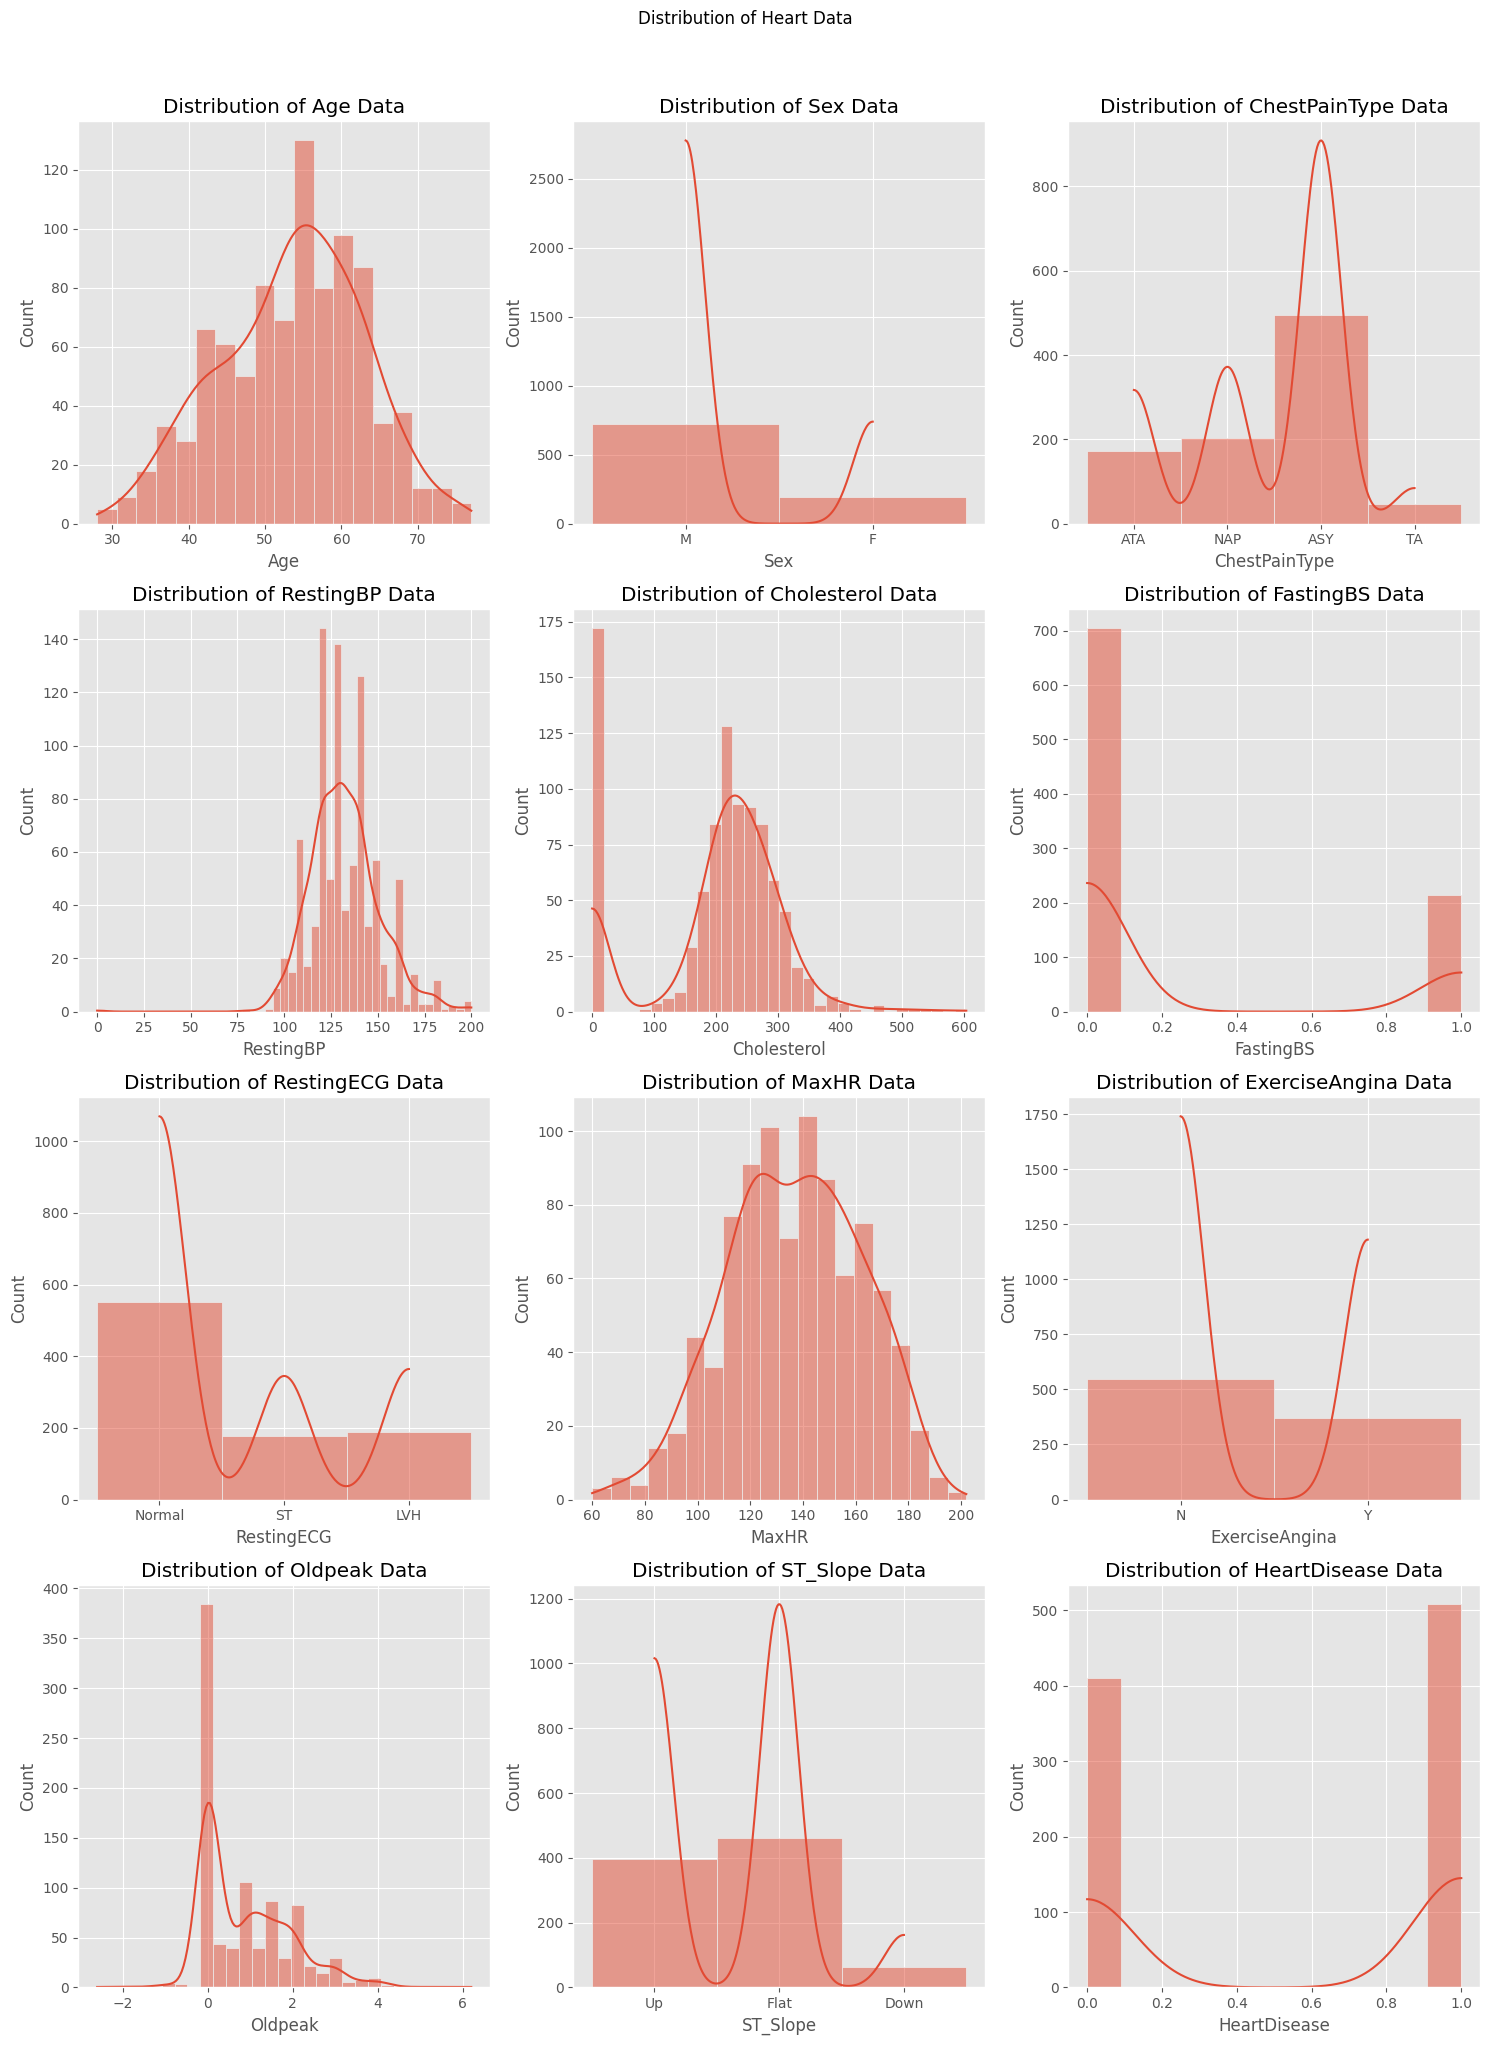

In [22]:
# Plot distributions with KDE
plot_distributions(heart_df, title="Distribution of Heart Data")

In [23]:
# Create box plot (finding outliers)
create_box_plot(heart_df, x_column="HeartDisease", y_column="Age", title="Distribution of Age by Heart Disease")